# Analyse de l'impact des données météorologiques sur l'économie avec spark

## Importation des packages

In [199]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg,desc, sum,max,corr,date_trunc, col, year, month, dayofmonth, hour, minute, second, weekofyear, date_format
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType
import matplotlib.pyplot as plt
import pandas as pd
import setuptools
from pyspark.sql.window import Window
import pyspark.sql.functions as F
import seaborn as sns
from df import groupage, graphique, filtre, df

In [200]:
# Initialisation de la session Spark
#spark_session = SparkSession.builder.appName("Analyse").getOrCreate()

In [201]:
#df = spark_session.read.csv('./data/donnees.csv',header = True, inferSchema=True)

In [202]:
df.show(3)

+-----+-------------------+----------------------+---------------------------------+-----------------------------+-----------------------------+---------------------------+-----------+--------------+--------+----------------------+-------------+----------------+-----------------------+------------------------------+-------------------------------------+------------------------------------------+-----------------+------------+--------+---------+
|index|         Date_Heure|Pression au niveau mer|Variation de pression en 3 heures|Type de tendance barométrique|Direction du vent moyen 10 mn|Vitesse du vent moyen 10 mn|Température|Point de rosée|Humidité|Visibilité horizontale|Temps présent|Pression station|Rafales sur une période|Periode de mesure de la rafale|Précipitations dans la dernière heure|Précipitations dans les 3 dernières heures| Température (°C)|consommation|datehour|datemonth|
+-----+-------------------+----------------------+---------------------------------+------------------

### Fonction d'agrégation des données en fonction du temps

In [203]:
'''
# Agrégation des données horaires en données journalières en utilisant la moyenne
def groupage(base, temps : str):
    base_agregee = base.groupBy(date_trunc(temps, col("Date_Heure")).alias("Date_Heure")).agg(
        avg("Pression au niveau mer").alias("Pression au niveau mer"),
        avg("Variation de pression en 3 heures").alias("Variation de pression en 3 heures"),
        avg("Type de tendance barométrique").alias("Type de tendance barométrique"),
        avg("Direction du vent moyen 10 mn").alias("Direction du vent moyen 10 mn"),
        avg("Vitesse du vent moyen 10 mn").alias("Vitesse du vent moyen 10 mn"),
        avg("Température").alias("Température"),
        avg("Point de rosée").alias("Point de rosée"),
        avg("Humidité").alias("Humidité"),
        avg("Visibilité horizontale").alias("Visibilité horizontale"),
        avg("Temps présent").alias("Temps présent"),
        avg("Pression station").alias("Pression station"),
        max("Rafales sur une période").alias("Rafales sur une période"),
        avg("Periode de mesure de la rafale").alias("Periode de mesure de la rafale"),
        avg("Précipitations dans la dernière heure").alias("Précipitations dans la dernière heure"),
        sum("Précipitations dans les 3 dernières heures").alias("Précipitations dans les 3 dernières heures"),
        avg("Température (°C)").alias("Température (°C)"),
        avg("consommation").alias("consommation")
    )
    base_agregee = base_agregee.withColumn("Jour", dayofmonth(col("Date_Heure"))) \
       .withColumn("Mois", month(col("Date_Heure"))) \
       .withColumn("Annee", year(col("Date_Heure")))
    
    # Ajout d'un nouvel index pour chaque ligne
    window_spec = Window.orderBy("Date_Heure")
    base_agregee = base_agregee.withColumn("index", F.row_number().over(window_spec))
    # Réorganiser les colonnes pour que 'index' soit la première colonne
    base_agregee = base_agregee.select("index", *[col for col in base_agregee.columns if col != "index"])
    return base_agregee
'''

'\n# Agrégation des données horaires en données journalières en utilisant la moyenne\ndef groupage(base, temps : str):\n    base_agregee = base.groupBy(date_trunc(temps, col("Date_Heure")).alias("Date_Heure")).agg(\n        avg("Pression au niveau mer").alias("Pression au niveau mer"),\n        avg("Variation de pression en 3 heures").alias("Variation de pression en 3 heures"),\n        avg("Type de tendance barométrique").alias("Type de tendance barométrique"),\n        avg("Direction du vent moyen 10 mn").alias("Direction du vent moyen 10 mn"),\n        avg("Vitesse du vent moyen 10 mn").alias("Vitesse du vent moyen 10 mn"),\n        avg("Température").alias("Température"),\n        avg("Point de rosée").alias("Point de rosée"),\n        avg("Humidité").alias("Humidité"),\n        avg("Visibilité horizontale").alias("Visibilité horizontale"),\n        avg("Temps présent").alias("Temps présent"),\n        avg("Pression station").alias("Pression station"),\n        max("Rafales sur une

### Analyse descriptive des variables

In [204]:
# Agrégation des données par jour et par mois
df_mensuel = groupage(df, "month")
df_journalier = groupage(df, "day")

In [205]:
df_mensuel.show(5)
df_journalier.show(5)

+-----+-------------------+----------------------+---------------------------------+-----------------------------+-----------------------------+---------------------------+------------------+------------------+------------------+----------------------+-----------------+------------------+-----------------------+------------------------------+-------------------------------------+------------------------------------------+------------------+------------------+----+----+-----+
|index|         Date_Heure|Pression au niveau mer|Variation de pression en 3 heures|Type de tendance barométrique|Direction du vent moyen 10 mn|Vitesse du vent moyen 10 mn|       Température|    Point de rosée|          Humidité|Visibilité horizontale|    Temps présent|  Pression station|Rafales sur une période|Periode de mesure de la rafale|Précipitations dans la dernière heure|Précipitations dans les 3 dernières heures|  Température (°C)|      consommation|Jour|Mois|Annee|
+-----+-------------------+-------------

#### Relation entre la consommation d'électricité et quelques variables de la base de données

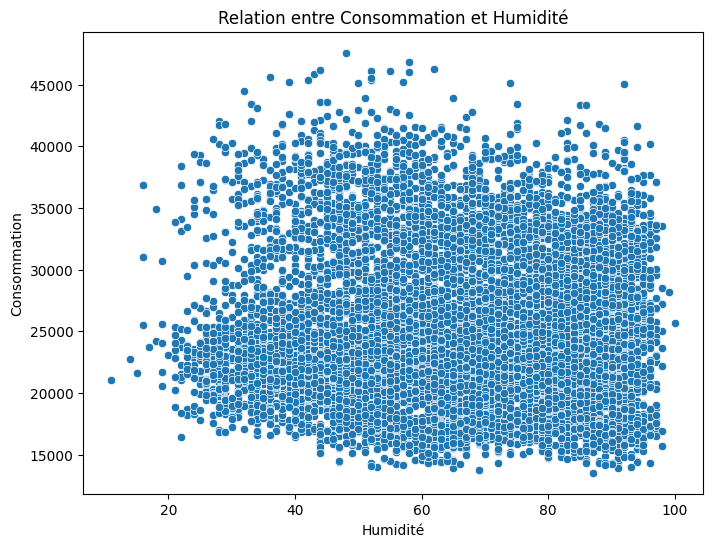

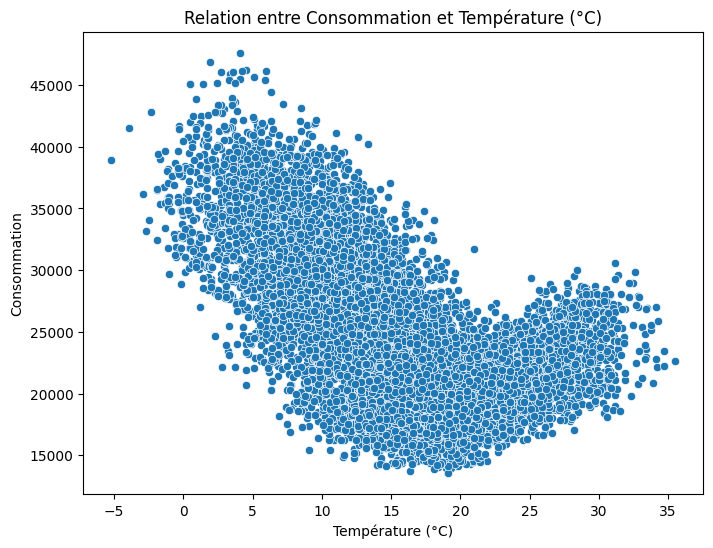

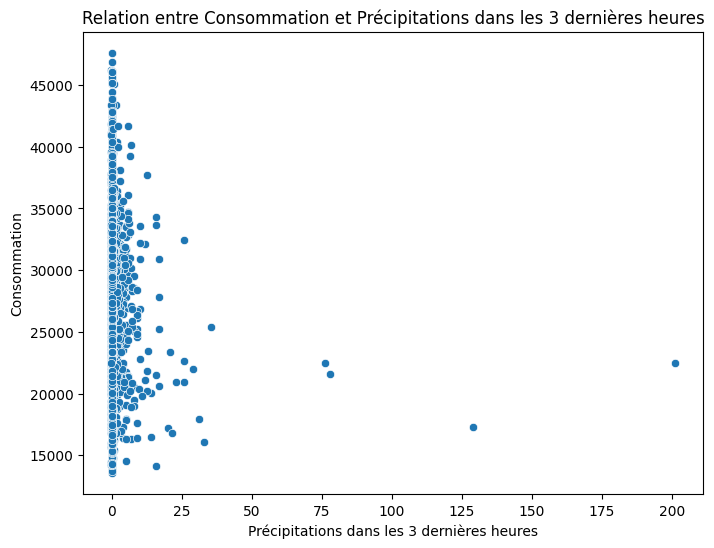

In [206]:
variables = ["Humidité","Température (°C)","Précipitations dans les 3 dernières heures"]

# Convertir le DataFrame Spark en DataFrame Pandas
pandas_df = df.limit(10000).toPandas()

# Tracer un graphique de dispersion avec Seaborn
for var in variables:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pandas_df[var], y=pandas_df["consommation"])
    plt.title(f"Relation entre Consommation et {var}")
    plt.xlabel(var)
    plt.ylabel("Consommation")
    plt.show()

In [207]:

# Corrélation entre consommation et la liste des variables
for var in variables:
    coef = corr("consommation", var)
    df_correlation = df.select(
        coef.alias(f"Corrélation Consommation d'électricité-{var}"))
    df_correlation.show()


+-----------------------------------------------+
|Corrélation Consommation d'électricité-Humidité|
+-----------------------------------------------+
|                           -0.01251159971725...|
+-----------------------------------------------+

+-------------------------------------------------------+
|Corrélation Consommation d'électricité-Température (°C)|
+-------------------------------------------------------+
|                                    -0.5860084235105774|
+-------------------------------------------------------+

+---------------------------------------------------------------------------------+
|Corrélation Consommation d'électricité-Précipitations dans les 3 dernières heures|
+---------------------------------------------------------------------------------+
|                                                             0.001255820176861...|
+---------------------------------------------------------------------------------+



On constate que la consommation d'électricité est correlée négativement à la température mais pas de corrélation avec les autres variables de la base.

### Représentation des évolutions des données météorologiques et la consommation dans le temps.

In [208]:
'''
#Fonction servant à filtrer les données afin de pour faire des représentations en fonction des périodes.
def filtre(base, variable, valeur):
    filtered_df = base.filter(base[variable] == valeur)
    return filtered_df
'''

'\n#Fonction servant à filtrer les données afin de pour faire des représentations en fonction des périodes.\ndef filtre(base, variable, valeur):\n    filtered_df = base.filter(base[variable] == valeur)\n    return filtered_df\n'

In [209]:
'''
# Conversion en DataFrame Pandas
def graphique(base, variable):
    pandas_df = base.toPandas()

    plt.figure(figsize=(10, 6))
    plt.plot(pandas_df['Date_Heure'], pandas_df[variable])
    #plt.title(f'Température en 2015')
    plt.xlabel('Date et Heure')
    plt.ylabel(f'{variable}')
    plt.show()
'''

"\n# Conversion en DataFrame Pandas\ndef graphique(base, variable):\n    pandas_df = base.toPandas()\n\n    plt.figure(figsize=(10, 6))\n    plt.plot(pandas_df['Date_Heure'], pandas_df[variable])\n    #plt.title(f'Température en 2015')\n    plt.xlabel('Date et Heure')\n    plt.ylabel(f'{variable}')\n    plt.show()\n"

In [ ]:
['index',
 'Date_Heure',
 'Pression au niveau mer',
 'Variation de pression en 3 heures',
 'Type de tendance barométrique',
 'Direction du vent moyen 10 mn',
 'Vitesse du vent moyen 10 mn',
 'Température',
 'Point de rosée',
 'Humidité',
 'Visibilité horizontale',
 'Temps présent',
 'Pression station',
 'Rafales sur une période',
 'Periode de mesure de la rafale',
 'Précipitations dans la dernière heure',
 'Précipitations dans les 3 dernières heures',
 'Température °C)',
 'consommation',
 'datehour',
 'datemonth']

In [210]:
df.dtypes

[('index', 'int'),
 ('Date_Heure', 'timestamp'),
 ('Pression au niveau mer', 'double'),
 ('Variation de pression en 3 heures', 'double'),
 ('Type de tendance barométrique', 'double'),
 ('Direction du vent moyen 10 mn', 'double'),
 ('Vitesse du vent moyen 10 mn', 'double'),
 ('Température', 'double'),
 ('Point de rosée', 'double'),
 ('Humidité', 'double'),
 ('Visibilité horizontale', 'double'),
 ('Temps présent', 'double'),
 ('Pression station', 'double'),
 ('Rafales sur une période', 'double'),
 ('Periode de mesure de la rafale', 'double'),
 ('Précipitations dans la dernière heure', 'double'),
 ('Précipitations dans les 3 dernières heures', 'double'),
 ('Température (°C)', 'double'),
 ('consommation', 'double'),
 ('datehour', 'int'),
 ('datemonth', 'int')]

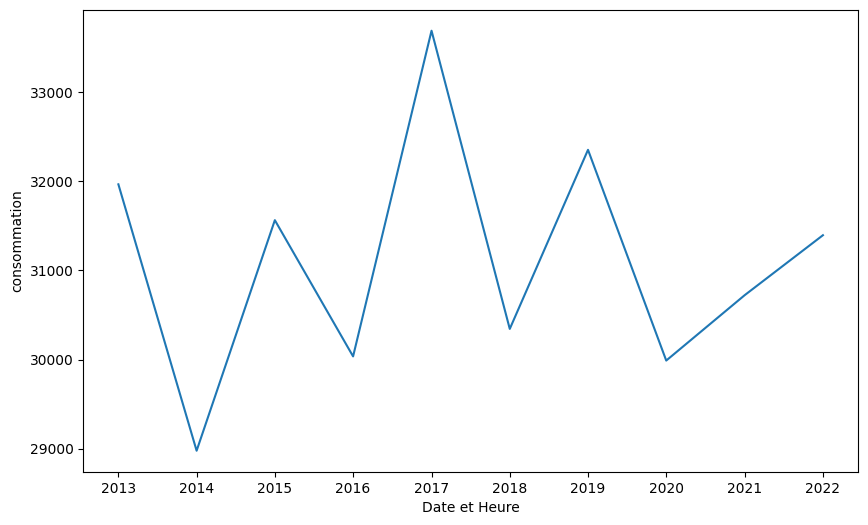

In [214]:
#Filtre de la période et représentation d'une variable sur cette période
data_filtered = filtre(df_mensuel,"Mois", 1)
graphique(data_filtered, "consommation")